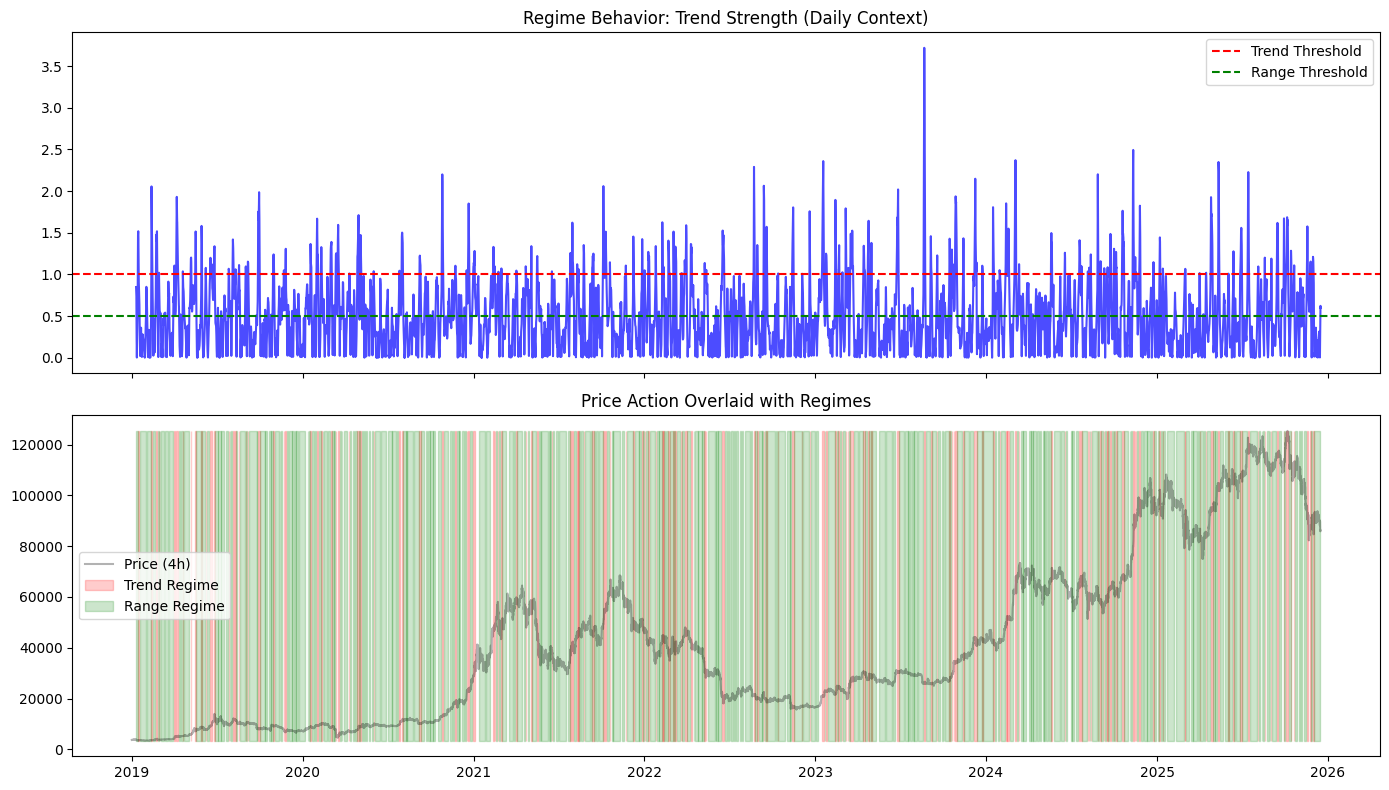

Updated btc_usdt_features.csv with 'trend_strength' and 'regime' columns.

Regime Counts:
regime
RANGE        8935
UNCERTAIN    4555
TREND        1699
UNKNOWN        55
Name: count, dtype: int64


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. Load the features file generated by your technical.py
df = pd.read_csv("../data/btc_usdt_features.csv", index_col=0, parse_dates=True)

# 2. Calculate Daily ATR for normalization
# Note: We use D_high, D_low, D_close to ensure no lookahead bias
def calculate_daily_atr(df, window=14):
    tr1 = df["D_high"] - df["D_low"]
    tr2 = (df["D_high"] - df["D_close"].shift()).abs()
    tr3 = (df["D_low"] - df["D_close"].shift()).abs()
    true_range = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    return true_range.rolling(window=window).mean()

df["atr_D"] = calculate_daily_atr(df)

# 3. Calculate Trend Strength Proxy (Daily SMA Distance / Daily ATR)
# This identifies if the "Big Trend" is moving or ranging
df["trend_strength"] = (
    (df["sma_20_D"] - df["sma_50_D"]).abs() / df["atr_D"]
)

# 4. Label Regimes based on thresholds
def label_regime(ts):
    if pd.isna(ts): return "UNKNOWN"
    if ts > 1.0: return "TREND"
    elif ts < 0.5: return "RANGE"
    else: return "UNCERTAIN"

df["regime"] = df["trend_strength"].apply(label_regime)

# 5. Visualize Results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Plot 1: Trend Strength
ax1.plot(df.index, df["trend_strength"], color='blue', alpha=0.7)
ax1.axhline(y=1.0, color='red', linestyle='--', label="Trend Threshold")
ax1.axhline(y=0.5, color='green', linestyle='--', label="Range Threshold")
ax1.set_title("Regime Behavior: Trend Strength (Daily Context)")
ax1.legend()

# Plot 2: Close Price with Regime Highlights
ax2.plot(df.index, df["close"], color='black', alpha=0.3, label="Price (4h)")
# Highlight "TREND" periods in light red
ax2.fill_between(df.index, df["close"].min(), df["close"].max(), 
                 where=(df["regime"] == "TREND"), color='red', alpha=0.2, label="Trend Regime")
# Highlight "RANGE" periods in light green
ax2.fill_between(df.index, df["close"].min(), df["close"].max(), 
                 where=(df["regime"] == "RANGE"), color='green', alpha=0.2, label="Range Regime")
ax2.set_title("Price Action Overlaid with Regimes")
ax2.legend()

plt.tight_layout()
plt.show()

# 6. Save updated features
df.to_csv("../data/btc_usdt_features.csv")
print("Updated btc_usdt_features.csv with 'trend_strength' and 'regime' columns.")
print("\nRegime Counts:")
print(df["regime"].value_counts())


In [6]:
# 1. Calculate the BB Width
df["bb_width_D"] = (df["bb_upper_D"] - df["bb_lower_D"]) / df["bb_mid_D"]

# 2. PRE-CALCULATE the 20th percentile threshold (the "Squeeze" level)
# This creates a column where each row knows what the 'squeeze' level was at that time
df["squeeze_threshold"] = df["bb_width_D"].rolling(100).quantile(0.2)

def identify_refined_regime(row):
    # 1. Trend Strength
    is_trending = row["trend_strength"] > 1.0
    
    # 2. Bollinger Position (%B)
    bb_range = row["bb_upper_4h"] - row["bb_lower_4h"]
    b_percent = (row["close"] - row["bb_lower_4h"]) / bb_range if bb_range != 0 else 0.5
    
    if is_trending:
        if b_percent > 0.8: return "TREND_BULLISH_EXPANSION"
        if b_percent < 0.2: return "TREND_BEARISH_EXPANSION"
        return "TREND_RETRACEMENT"
    else:
        # 3. Compare the row's width to its specific threshold
        # We use row["squeeze_threshold"] which we calculated above
        if row["bb_width_D"] < row["squeeze_threshold"]:
            return "RANGE_SQUEEZE"
        return "RANGE_CHOP"

# Now the apply will work because it's comparing two single numbers
df["refined_regime"] = df.apply(identify_refined_regime, axis=1)

# Preview
print(df["refined_regime"].value_counts())


refined_regime
RANGE_CHOP                 10712
RANGE_SQUEEZE               2833
TREND_RETRACEMENT            964
TREND_BULLISH_EXPANSION      437
TREND_BEARISH_EXPANSION      298
Name: count, dtype: int64


In [7]:
# 1. Final calculations
df["bb_width_D"] = (df["bb_upper_D"] - df["bb_lower_D"]) / df["bb_mid_D"]
df["squeeze_threshold"] = df["bb_width_D"].rolling(100).quantile(0.2)
df["refined_regime"] = df.apply(identify_refined_regime, axis=1)

# 2. Save the updated dataframe
df.to_csv("../data/btc_usdt_features.csv")
print("Features file updated successfully.")


Features file updated successfully.
